In [1]:
# import libraries
import numpy as np
import sys
import psi4
from helper_PFCI import PFHamiltonianGenerator
np.set_printoptions(threshold=sys.maxsize)
import scipy
from scipy.optimize import curve_fit
from scipy import interpolate
from matplotlib import pyplot as plt
import matplotlib
from scipy import constants
from numpy.polynomial import Polynomial
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
import seaborn as sns
import pandas as pd

In [2]:
import os
print(os.path.abspath("."))

/Users/ptolley1/Documents/GitHub/SCQED-PCQED/src


In [3]:
#calculate some constants for LiH

amu_to_au = 1822.89


mA_kg = 1.00784 * (10 ** (-3) / (6.022 * 10 ** 23) )
mB_kg = 6.9410 * (10 ** (-3) / (6.022 * 10 ** 23) )
mA_au = 1.00784 * amu_to_au
mB_au = 6.9410 * amu_to_au
mu_au = (mA_au * mB_au )/ (mA_au + mB_au)
mu_kg = (mA_kg * mB_kg) / (mA_kg + mB_kg)  
print("mu_au: ", mu_au)

mu_au:  1604.2437006156372


In [4]:
"""
def declutter_E_array(E_array, delta=0.002, num_to_declutter = 6):


    E_array = np.copy(E_array)
    new_E_array = np.zeros_like(E_array)

    for i in range(0,num_to_declutter):
        previous_intersection = 0
        for z in range(0,200):
            for j in range(i+1, E_array.shape[1]):
                array1 = E_array[:, i]
                array2 = E_array[:, j]

                #find closest points
                idx =(np.abs(array1[previous_intersection:] - array2[previous_intersection:])).argmin() + previous_intersection


                #assume they crossover if they get really close
                if np.abs(array1[idx]- array2[idx]) < delta:
                        
                    #copy one of the arrays
                    array1_copy = np.array(array1, copy=True)

                    array1 = np.concatenate([array1[:idx],  array2[idx:]])
                    array2 =np.concatenate([array2[:idx] , array1_copy[idx:]])


                    E_array[:,i] = array1
                    E_array[:,j] = array2

                previous_intersection = idx

        new_E_array[:,i ] = E_array[:,i]

    return new_E_array
"""

'\ndef declutter_E_array(E_array, delta=0.002, num_to_declutter = 6):\n\n\n    E_array = np.copy(E_array)\n    new_E_array = np.zeros_like(E_array)\n\n    for i in range(0,num_to_declutter):\n        previous_intersection = 0\n        for z in range(0,200):\n            for j in range(i+1, E_array.shape[1]):\n                array1 = E_array[:, i]\n                array2 = E_array[:, j]\n\n                #find closest points\n                idx =(np.abs(array1[previous_intersection:] - array2[previous_intersection:])).argmin() + previous_intersection\n\n\n                #assume they crossover if they get really close\n                if np.abs(array1[idx]- array2[idx]) < delta:\n                        \n                    #copy one of the arrays\n                    array1_copy = np.array(array1, copy=True)\n\n                    array1 = np.concatenate([array1[:idx],  array2[idx:]])\n                    array2 =np.concatenate([array2[:idx] , array1_copy[idx:]])\n\n\n             

In [5]:
def declutter_E_array(E_array, discontinuity_threshold=0.0001, energy_diff_threshold = 0.02,  num_to_declutter = 2):

    E_array = np.copy(E_array)
    new_E_array = np.zeros_like(E_array)

    for i in range(0,num_to_declutter):
        previous_intersection = 0
        for z in range(0,50):
            for j in range(i+1, E_array.shape[1]):
                array1 = E_array[:, i]
                array2 = E_array[:, j]

                array1_from_previous_intersection = array1[previous_intersection:]
                array2_from_previous_intersection = array2[previous_intersection:]


                #find closest points
                closest_indices =np.where(np.abs(array1[previous_intersection:] - array2[previous_intersection:]) < energy_diff_threshold)
                if np.shape(closest_indices)[1] != 0:
                    #print(i)
                    #print(closest_indices)
                    pass


                try:
                    dy_1 = np.gradient(array1_from_previous_intersection)
                    idx_1 = np.where(abs(np.diff(dy_1)) >  discontinuity_threshold)[0]+1

                    dy_2= np.gradient(array2_from_previous_intersection)
                    idx_2 = np.where(abs(np.diff(dy_2)) > discontinuity_threshold)[0]+1

                    if (len(idx_1)!= 0 and len(idx_2) != 0 ):

                        mask_idx1_idx2 = np.isin(idx_1, idx_2)
                        indices_idx1_in_idx2 = np.where(mask_idx1_idx2)[0]
                        indices_idx1_in_idx2 = idx_1[indices_idx1_in_idx2]
                        #print(indices_idx1_in_idx2)


                        starting_index=0
                        for elem_index in range(len(indices_idx1_in_idx2)-1):
                            if indices_idx1_in_idx2[elem_index]+1 == indices_idx1_in_idx2[elem_index+1]:
                                starting_index = elem_index+1
                        indices_idx1_in_idx2 = indices_idx1_in_idx2[starting_index:]
                        
                            
                        

                        if(len(indices_idx1_in_idx2) != 0 ):

                            mask_discontinuties_energydiff = np.isin(indices_idx1_in_idx2, closest_indices)
                            indices_discontinuties_in_energydiff = np.where(mask_discontinuties_energydiff)[0]
                            #print(indices_discontinuties_in_energydiff)

                            if len(indices_discontinuties_in_energydiff) != 0 :

                                idx = indices_idx1_in_idx2[indices_discontinuties_in_energydiff[0]]+ previous_intersection
                                #print(idx)

                                array1_copy = np.array(array1, copy=True)

                                array1 = np.concatenate([array1[:idx],  array2[idx:]])
                                array2 =np.concatenate([array2[:idx] , array1_copy[idx:]])


                                E_array[:,i] = array1
                                E_array[:,j] = array2


                                previous_intersection = idx
                except():
                    print(i)

        new_E_array[:,i ] = E_array[:,i]

    return new_E_array

In [6]:
#new_cavity_E_array = declutter_E_array(cavity_E_array, 0.00001, 0.002,num_to_declutter=9)
# new_cavity_E_array_2 = declutter_E_array(cavity_E_array_2,0.000005, 0.002, num_to_declutter=9)
# plt.plot(r_data, new_cavity_E_array)
# plt.ylim(-8.1,-7.7)
# plt.show()


# plt.plot(r_data, new_cavity_E_array_2)
# plt.ylim(-8.1,-7.7)
# plt.show()


In [8]:

cavity_free_E_array = np.load("/Users/ptolley1/Documents/github/SCQED-PCQED/array_data/LiH_cs_5_photons/fci_cavity_free_array_LIH_6311g.npy")
cavity_E_array_0_06  = np.load("/Users/ptolley1/Documents/github/SCQED-PCQED/array_data/LiH_cs_5_photons/cs_5_photons_fci_cavity_arrays_LIH_6311g0_06.npy")
cavity_E_array_0_05  = np.load("/Users/ptolley1/Documents/github/SCQED-PCQED/array_data/LiH_cs_5_photons/cs_5_photons_fci_cavity_arrays_LIH_6311g0_05.npy")
cavity_E_array_0_04  = np.load("/Users/ptolley1/Documents/github/SCQED-PCQED/array_data/LiH_cs_5_photons/cs_5_photons_fci_cavity_arrays_LIH_6311g0_04.npy")
cavity_E_array_0_03  = np.load("/Users/ptolley1/Documents/github/SCQED-PCQED/array_data/LiH_cs_5_photons/cs_5_photons_fci_cavity_arrays_LIH_6311g0_03.npy")
cavity_E_array_0_02  = np.load("/Users/ptolley1/Documents/github/SCQED-PCQED/array_data/LiH_cs_5_photons/cs_5_photons_fci_cavity_arrays_LIH_6311g0_02.npy")
cavity_E_array_0_01  = np.load("/Users/ptolley1/Documents/github/SCQED-PCQED/array_data/LiH_cs_5_photons/cs_5_photons_fci_cavity_arrays_LIH_6311g0_01.npy")
cavity_E_array_0_005  = np.load("/Users/ptolley1/Documents/github/SCQED-PCQED/array_data/LiH_cs_5_photons/cs_5_photons_fci_cavity_arrays_LIH_6311g0_005.npy")
r_data = np.load("/Users/ptolley1/Documents/github/SCQED-PCQED/array_data/LiH_cs_5_photons/fci_r_array_LIH_6311g.npy")

In [9]:
cavity_free_E_array = declutter_E_array(cavity_free_E_array, 0.00001, 0.002,num_to_declutter=9)
cavity_E_array_0_05  = declutter_E_array(cavity_E_array_0_05, 0.00001, 0.002,num_to_declutter=9)
cavity_E_array_0_04  = declutter_E_array(cavity_E_array_0_04, 0.00001, 0.002,num_to_declutter=9)
cavity_E_array_0_03  = declutter_E_array(cavity_E_array_0_03, 0.00001, 0.002,num_to_declutter=9)
cavity_E_array_0_02  = declutter_E_array(cavity_E_array_0_02, 0.00001, 0.002,num_to_declutter=9)
cavity_E_array_0_01  = declutter_E_array(cavity_E_array_0_01, 0.00001, 0.002,num_to_declutter=9)
cavity_E_array_0_005  = declutter_E_array(cavity_E_array_0_005 ,0.000005, 0.002, num_to_declutter=9)

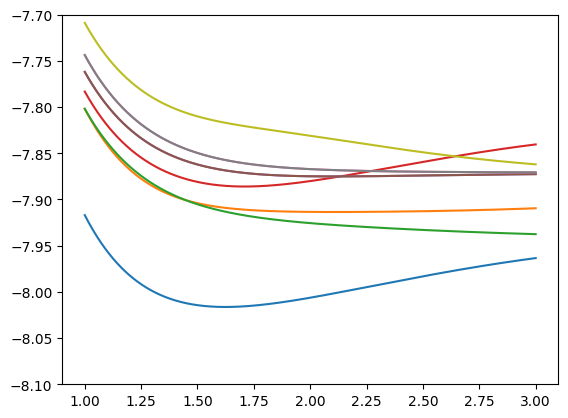

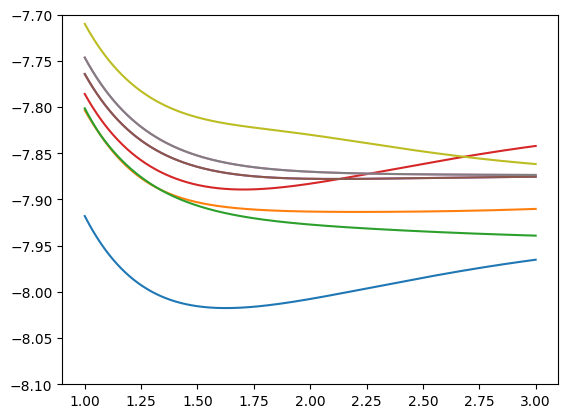

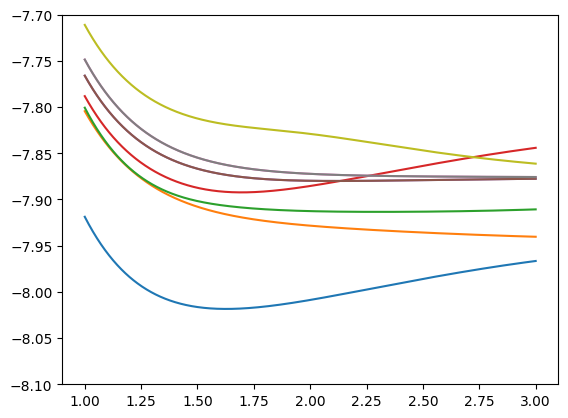

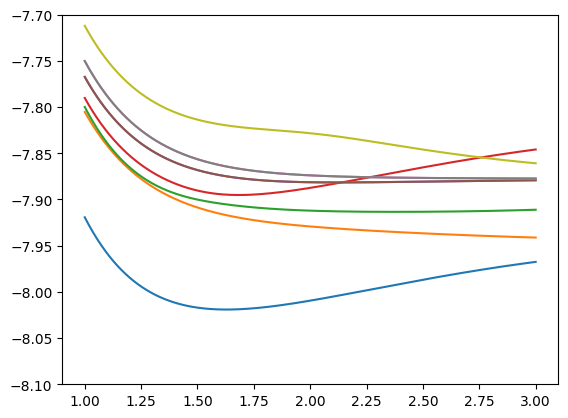

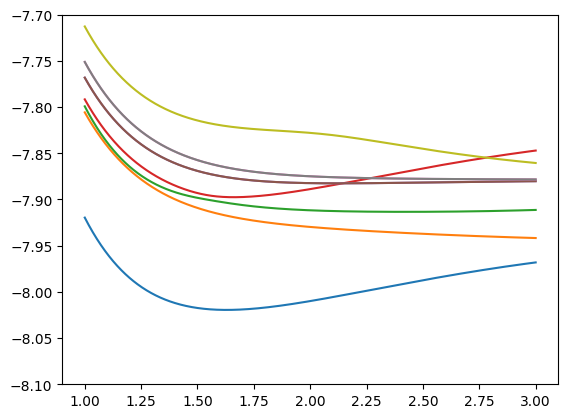

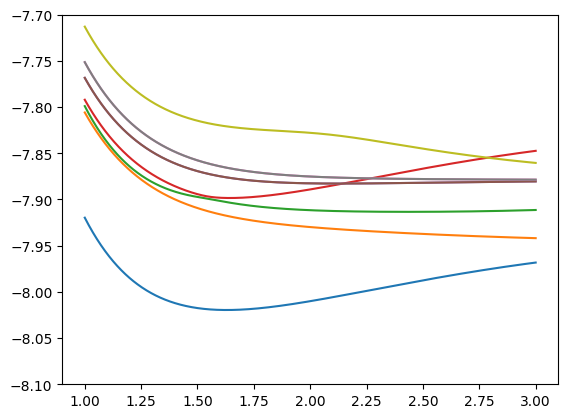

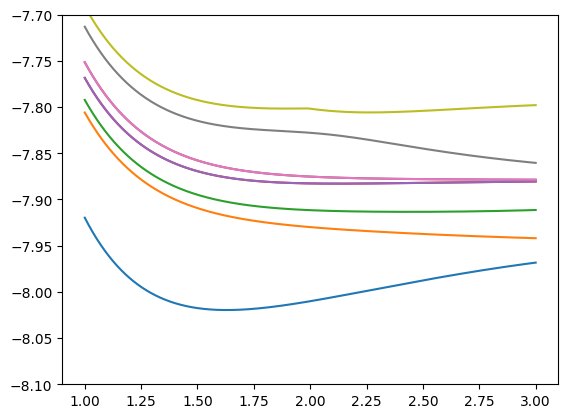

In [10]:
#plt.plot(r_data, cavity_E_array_0_1 )
#plt.ylim(-8.1,-7.7)
#plt.show()
plt.plot(r_data, cavity_E_array_0_05 )
plt.ylim(-8.1,-7.7)
plt.show()
plt.plot(r_data, cavity_E_array_0_04 )
plt.ylim(-8.1,-7.7)
plt.show()
plt.plot(r_data, cavity_E_array_0_03 )
plt.ylim(-8.1,-7.7)
plt.show()
plt.plot(r_data, cavity_E_array_0_02 )
plt.ylim(-8.1,-7.7)
plt.show()
plt.plot(r_data, cavity_E_array_0_01 )
plt.ylim(-8.1,-7.7)
plt.show()
plt.plot(r_data, cavity_E_array_0_005 )
plt.ylim(-8.1,-7.7)
plt.show()
plt.plot(r_data,cavity_free_E_array)
plt.ylim(-8.1,-7.7)
plt.show()

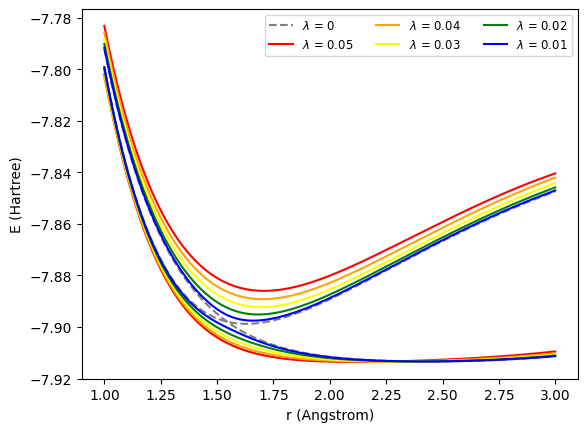

In [14]:


LP_0_005 = cavity_E_array_0_005[:, 2]
UP_0_005 = cavity_E_array_0_005[:, 3]
LP_0_01 = cavity_E_array_0_01[:, 2]
UP_0_01 = cavity_E_array_0_01[:, 3]
LP_0_02 = cavity_E_array_0_02[:, 2]
UP_0_02 = cavity_E_array_0_02[:, 3]
LP_0_03 = cavity_E_array_0_03[:, 2]
UP_0_03 = cavity_E_array_0_03[:, 3]
LP_0_04 = cavity_E_array_0_04[:, 1]
UP_0_04 = cavity_E_array_0_04[:,3]
LP_0_05 = cavity_E_array_0_05[:, 1]
UP_0_05 = cavity_E_array_0_05[:, 3]




fci_S0 = cavity_free_E_array[:,0]
fci_S1 = cavity_free_E_array[:,2]
plt.plot(r_data, fci_S0 + 0.12086, color = 'grey', linestyle = 'dashed', label=f'$\lambda$ = 0')
plt.plot(r_data, fci_S1, 'grey', linestyle = 'dashed')
plt.plot(r_data, LP_0_05, 'red', label=f'$\lambda$ = 0.05')
plt.plot(r_data, UP_0_05,'red')
plt.plot(r_data, LP_0_04,'orange', label=f'$\lambda$ = 0.04')
plt.plot(r_data, UP_0_04,'orange')
plt.plot(r_data, LP_0_03,'yellow', label=f'$\lambda$ = 0.03')
plt.plot(r_data, UP_0_03,'yellow')
plt.plot(r_data, LP_0_02,'green', label=f'$\lambda$ = 0.02')
plt.plot(r_data, UP_0_02,'green')
plt.plot(r_data, LP_0_01,'blue', label=f'$\lambda$ = 0.01')
plt.plot(r_data, UP_0_01,'blue')

plt.xlabel('r (Angstrom)')
plt.ylabel('E (Hartree)')

plt.legend(loc = 'upper right', ncols = 3, fontsize = 'small')
plt.savefig('ppsurfaces.png',dpi=500)
plt.show()

In [ ]:

hbar = 1

# number of grid points 
N = 2001


def get_fd_wfn(x, V_y: np.array, use_5_point_stencil = False):

    hbar = 1


    # define grid spacing h
    h = x[1]-x[0]

    # create arrays for T, V, and H - we truncate the smallest and largest grid points where 
    # the centered finite difference derivatives cannot be defined
    T = np.zeros((N-2, N-2))
    V = np.zeros((N-2, N-2))
    H = np.zeros((N-2, N-2))

    # this uses the 3 point stencil; we can adapt to use a 5 point and it might improve accuracy


    if not use_5_point_stencil:
        for i in range(N-2):
            for j in range(N-2):
                if i==j:
                    T[i,j]= -2
                elif np.abs(i-j)==1:
                    T[i,j]=1
                else:
                    T[i,j]=0

        T = -T *( hbar ** 2 / (2 * mu_au* h**2))
        #T =  (- (hbar ** 2) / (2* mu_kg)) *  (1 / ( h**2)) * joule_to_hartree  * T


    elif use_5_point_stencil:
        for i in range(N-2):
            for j in range(N-2):
                if i==j:
                    T[i,j]= -30
                elif np.abs(i-j)==1:
                    T[i,j]=16
                elif np.abs(i-j)==2:
                    T[i,j]=-1

        T = -T *  ((hbar ** 2) / (2* mu_au))*  (1 / ( 12 * h**2)) 


    for i in range(N-2):
        for j in range(N-2):
            if i==j:
                V[i,j]= V_y[i+1]
            else:
                V[i,j]=0
                
    H = T + V

    #print((-T * hbar ** 2 / (2 * mu_kg* h**2)) * (2.294 * 10 ** 17))
    #print(V)

    vals, vecs = np.linalg.eigh(H)

    if np.average(vecs[:, 0]) < 0:
        vecs = vecs * -1

    return vals, vecs

In [ ]:
#FCF calculator
def get_fcf_matrix(potential_1, potential_2, r_data, matrix_size = 6, potential_1_is_groundstate = False):

    #geneerate 2 sets of wavefunctions for the potentials

    r_data_au = r_data / psi4.constants.bohr2angstroms

    min_potential_1_loc = np.argmin(potential_1[:])
    r_eq_au =r_data_au[potential_1.argmin()]

    print("r_eq_au : " , r_eq_au)


    # Fitting S0 PES to a quintic polynomial

    poly = np.poly1d(np.polyfit(r_data_au, potential_1, 7))

    poly_array = np.asarray(poly)


    #Taking first and second derivative of S0 PES and evaluating at r_eq
    first_derivative = poly.deriv()
    second_derivative = first_derivative.deriv()
    k_au = second_derivative(r_eq_au)
    print("k_au: ", k_au)


    angstrom_to_bohr = 1.88973
    x_min = r_data_au[0]
    x_max = r_data_au[-1]

    hbar = 1

    # number of grid points 
    N = 2001
    # define grid
    x = np.linspace(x_min, x_max, N)

    V_y = np.polyval(np.asarray(poly), (x))


    vals1, vecs1 = get_fd_wfn(x, V_y, use_5_point_stencil=True)
    #vals1, vecs1 = get_fd_wfn(x, V_y)



    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('bond length (m)')
    ax1.set_ylabel('wfn', color=color)
    ax1.plot(x[1:N-1], vecs1[:,0], 'r', label = "$\psi_0$")
    ax1.plot(x[1:N-1], vecs1[:,1], 'b',label = "$\psi_1$" )
    ax1.plot(x[1:N-1], vecs1[:,2], 'g',label = "$\psi_2$")
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('energy (hartree)', color=color)  # we already handled the x-label with ax1
    ax2.plot(r_data_au, potential_1, 'bo', label='PES_1')
    ax2.plot(r_data_au, poly(r_data_au), 'm-', label='fit')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    fig.legend()
    plt.show()


    min_potential_2_loc = np.argmin(potential_2[:])
    r_eq_au =r_data_au[min_potential_2_loc]

    print("r_eq_au : " , r_eq_au)


    # Fitting S0 PES to a quintic polynomial

    #can use this line to only fit to bottom of well for cubic and harmonic
    #poly = np.poly1d(np.polyfit(r_data_meters[50:100], fci_S0[50:100], 4))

    poly = np.poly1d(np.polyfit(r_data_au, potential_2, 7))

    poly_array = np.asarray(poly)


    #Taking first and second derivative of S0 PES and evaluating at r_eq
    first_derivative = poly.deriv()
    second_derivative = first_derivative.deriv()
    k_au = second_derivative(r_eq_au)
    print("k_au: ", k_au)


    angstrom_to_bohr = 1.88973
    x_min = r_data_au[0]
    x_max = r_data_au[-1]

    hbar = 1

    # number of grid points 
    N = 2001
    # define grid
    x = np.linspace(x_min, x_max, N)

    V_y = np.polyval(np.asarray(poly), (x))


    vals2, vecs2 = get_fd_wfn(x, V_y, use_5_point_stencil=True)
    #vals2, vecs2 = get_fd_wfn(x, V_y)



    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('bond length')
    ax1.set_ylabel('wfn', color=color)
    ax1.plot(x[1:N-1], vecs2[:,0], 'r',label = "$\psi_0$")
    ax1.plot(x[1:N-1], vecs2[:,1], 'b',label = "$\psi_1$")
    ax1.plot(x[1:N-1], vecs2[:,2], 'g', label = "$\psi_2$")

    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('energy (hartree)', color=color)  # we already handled the x-label with ax1
    ax2.plot(r_data_au, potential_2, 'bo', label='PES_2')
    ax2.plot(r_data_au, poly(r_data_au), 'm-', label='fit')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    fig.legend()
    plt.show()


    FCF_matrix = np.zeros((matrix_size,matrix_size))

    for i in range(FCF_matrix.shape[0]):
        for j in range(FCF_matrix.shape[0]):

            FCF_matrix[i][j] = np.trapz(vecs1[:,i] * vecs2[:,j]) 
            FCF = np.absolute(FCF_matrix) ** 2 

    return FCF




In [ ]:

fcf_0_05 = get_fcf_matrix(fci_S0,UP_0_05, r_data, 6)

fcf_0_04 = get_fcf_matrix(fci_S0,UP_0_04, r_data, 6)

fcf_0_03 = get_fcf_matrix(fci_S0,UP_0_03, r_data, 6)

fcf_0_02 = get_fcf_matrix(fci_S0,UP_0_02, r_data, 6)

fcf_0_01 = get_fcf_matrix(fci_S0,UP_0_01, r_data, 6)
fcf_0_005 = get_fcf_matrix(fci_S0,UP_0_005, r_data, 6)

In [ ]:
min_val, max_val = 0, 15
cm = sns.light_palette("blue", as_cmap=True)
x=pd.DataFrame(fcf_0_005)
x=x.style.background_gradient(cmap=cm)
display(x)

min_val, max_val = 0, 15
cm = sns.light_palette("blue", as_cmap=True)
x=pd.DataFrame(fcf_0_01)
x=x.style.background_gradient(cmap=cm)
display(x)

min_val, max_val = 0, 15
cm = sns.light_palette("blue", as_cmap=True)
x=pd.DataFrame(fcf_0_02)
x=x.style.background_gradient(cmap=cm)
display(x)

min_val, max_val = 0, 15
cm = sns.light_palette("blue", as_cmap=True)
x=pd.DataFrame(fcf_0_03)
x=x.style.background_gradient(cmap=cm)
display(x)

min_val, max_val = 0, 15
cm = sns.light_palette("blue", as_cmap=True)
x=pd.DataFrame(fcf_0_04)
x=x.style.background_gradient(cmap=cm)
display(x)

min_val, max_val = 0, 15
cm = sns.light_palette("blue", as_cmap=True)
x=pd.DataFrame(fcf_0_05)
x=x.style.background_gradient(cmap=cm)
display(x)